In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

CompileError: pyross/inference.pyx

In [1]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
print(N)
fi = Ni/N 

64111602.0


In [3]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]
        
N = N/5e2
Ni = Ni/5e2

In [4]:
# Generate class with contact matrix for SIR-type model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

def contactMatrix(t):
    return CH + CW + CS + CO

In [5]:
beta  = 0.04         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 


# initial conditions
E0   = np.array([100]*M)
A0   = np.array([100]*M)
Ia0  = np.array([10]*M)# each age group has asymptomatic infectives
Is0  = np.array([10]*M)# and also symptomatic infectives
Ih0  = np.array([5]*M)
Ic0  = np.array([5]*M)
Im0  = np.array([5]*M)
R0   = np.zeros(M)
S0   = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

# set up initial condition
#Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
#Is0 = np.array([10, 10])   # and also symptomatic infectives
#R0  = np.zeros((M))
#E0  = np.array([100, 100])
#A0  = np.array([100, 100])
#Ih0  = np.array([5, 5])
#Ic0  = np.array([5, 5])
#Im0  = np.array([5, 5])
#S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.stochastic.SEAI5R(parameters, M, Ni)
print(Ni)

Tf=100;  Nf=Tf+1 

data=model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, generator.constant_CM, Tf, Nf)

[31268.886 35668.366 35526.088 25759.864]


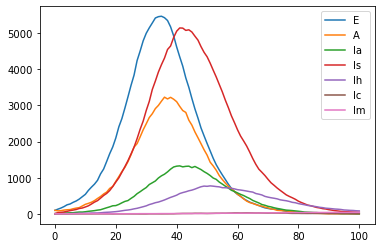

In [6]:
## Save pre intervention traj
data_array = data['X']

np.save('stoch_traj_latent_SEAI5R.npy', data_array)

# plot the stochastic solution 
plt.plot(data['X'][:, M], label='E')
plt.plot(data['X'][:, 2*M], label='A')
plt.plot(data['X'][:, 3*M], label='Ia')
plt.plot(data['X'][:, 4*M], label='Is')
plt.plot(data['X'][:, 5*M], label='Ih')
plt.plot(data['X'][:, 6*M], label='Ic')
plt.plot(data['X'][:, 7*M], label='Im')
plt.legend()
plt.show()

(32,) (101, 32)
(101, 32)


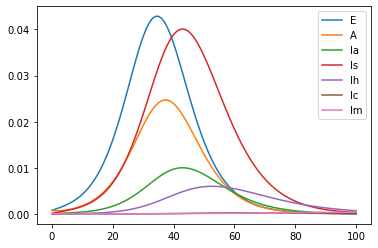

In [7]:
# load the data and rescale to intensive variables 
Tf = 100 # can truncate later 
Nf = Tf+1

x = np.load('stoch_traj_latent_SEAI5R.npy').astype('float')
x = (x/N)[:Nf,:8*M]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, False, False, True, True, True, True]), M)
print(fltr.shape, x.shape)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# estimate mean and cov 
det_model = pyross.deterministic.SEAI5R(parameters, int(M), fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
print(x_det.shape)
plt.plot(x_det[:, M], label='E')
plt.plot(x_det[:, 2*M], label='A')
plt.plot(x_det[:, 3*M], label='Ia')
plt.plot(x_det[:, 4*M], label='Is')
plt.plot(x_det[:, 5*M], label='Ih')
plt.plot(x_det[:, 6*M], label='Ic')
plt.plot(x_det[:, 7*M], label='Im')
plt.legend()
plt.show()

In [8]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 

logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-15032.24882661145
105.05639052391052


In [9]:
## Infer from only part of params

# load the data and rescale to intensive variables 
Tf_inference = 30 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('stoch_traj_latent_SEAI5R.npy').astype('float')
x = (x[:,:8*M]/N)[:Nf_inference]
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

## create filter to distinguish between observable classes
fltr=np.repeat(np.array([False, False, False, False, True, True, True, True]), M)
obs=x[:,fltr]
x0 = x[0]

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-4734.6684141183205
25.803686141967773


In [10]:
alpha_g = 0.3          ## bad initial guess
alpha_std = 0.1 
alpha_b = (0.1,0.5)

beta_g  = 0.03         ## bad initial guess
beta_std = 0.1 
beta_b = (1e-3, 1)

gIa_g   = 1./7    
gIa_std = 0.1 
gIa_b = (0.01, 1)

gIs_g   = 1./7 
gIs_std = 0.1 
gIs_b = (0.01, 1)

gE_g    = 0.2
gE_std = 0.05 
gE_b = (0.01, 1)

gA_g    = 0.3 
gA_std = 0.1 
gA_b = (0.01, 1) 
   

E0_g = E0/N 
E_std = E0_g*0.4 
bounds_for_E = np.tile([0.1/N, 100/N], M).reshape(M, 2)

A0_g = A0/N 
A_std = A0_g*0.4 
bounds_for_A = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Ia0_g = Ia0/N
Ia_std = Ia0_g*0.4 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Is0_g = Is0/N 
Is_std = Is0_g*0.2 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Ih0_g = (Ih0+1)/N
Ih_std = [1/N]*M 
bounds_for_Ih = np.tile([0.1/N, 10/N], M).reshape(M, 2)

Ih0_g = (Ih0+1)/N
Ih_std = [1/N]*M 
bounds_for_Ih = np.tile([0.1/N, 10/N], M).reshape(M, 2)

Ic0_g = (Ic0+1)/N
Ic_std = [1/N]*M 
bounds_for_Ic = np.tile([0.1/N, 10/N], M).reshape(M, 2)

Im0_g = (Im0+1)/N
Im_std = [1/N]*M 
bounds_for_Im = np.tile([0.1/N, 10/N], M).reshape(M, 2)

S0_g = S0/N
S_std = Ia_std*np.sqrt(5)
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)


# optimisation parameters 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
ftol = 1e-3 # the relative tol in (-logp)  

# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std])
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                   global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol, eps=eps) 
# the L-BFGS-B method prints to the terminal rather than here 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=419282, Fri May  1 09:55:59 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 inf 1.0e+00 9.43e-01  2e-02  3e-02 0:00.1
    2     32 inf 1.2e+00 8.53e-01  1e-02  3e-02 0:00.2
Optimal value (global minimisation):  inf
Starting local minimisation...


/usr/lib/python3.8/site-packages/cma-3.0.3-py3.8.egg/cma/utilities/utils.py:343: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]. (class=CMAEvolutionStrategy method=ask )
  warnings.warn(msg + ' (' +
/usr/lib/python3.8/site-packages/cma-3.0.3-py3.8.egg/cma/evolution_strategy.py:3591: RuntimeWarning: invalid value encountered in double_scalars
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)
/usr/lib/python3.8/site-packages/cma-3.0.3-py3.8.egg/cma/evolution_strategy.py:3592: RuntimeWarning: invalid value encountered in double_scalars
  historic_fitness_range = max(es.fit.hist) - min(es.fit.hist)
/usr/lib/python3.8/site-packages/cma-3.0.3-py3.8.egg/cma/evolution_strategy.py:3597: RuntimeWarning: invalid value encountered in double_scalars
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/usr/lib/py

TypeError: Wrong number or type of arguments for overloaded function 'opt_optimize'.
  Possible C/C++ prototypes are:
    nlopt::opt::optimize(std::vector< double,std::allocator< double > > &,double &)
    nlopt::opt::optimize(std::vector< double,std::allocator< double > > const &)


In [24]:
# save the parameters 
np.save('SEAI5R_latent_param.npy', params)

{'alpha': 0.1726461495874574, 'beta': 0.020130226867684908, 'gIa': 0.12024615891942374, 'gIs': 0.1472697387329405, 'fsa': 0.8}


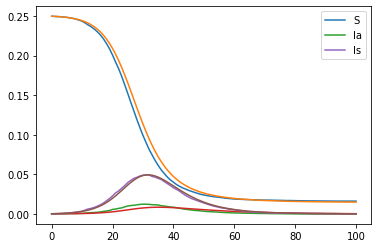

In [25]:
params = np.load('SEAI5R_latent_param.npy')

parameters = estimator.make_params_dict(params)
det_model = pyross.deterministic.SIR(parameters, M, fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, generator.constant_CM)
x = data['X']/N

plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='E')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='A')
plt.plot(x_det[:, 2*M])
plt.plot(x[:,3*M], label='Ia')
plt.plot(x_det[:, 3*M])
plt.plot(x[:,4*M], label='Is')
plt.plot(x_det[:, 4*M])
plt.plot(x[:,5*M], label='Ih')
plt.plot(x_det[:, 5*M])
plt.plot(x[:,6*M], label='Ic')
plt.plot(x_det[:, 6*M])
plt.plot(x[:,7*M], label='Im')
plt.plot(x_det[:, 7*M])
plt.legend()
plt.show()

plt.legend()
plt.show()